In [1]:
#!python -m pip install diffcp
# https://github.com/cvxgrp/diffcp
#!python -m pip install cvxpylayers
# https://github.com/cvxgrp/cvxpylayers


### Disciplined Parametrized Programming

https://www.cvxpy.org/tutorial/dpp/index.html#dpp

Parameters are symbolic representations of constants. Using parameters lets you modify the values of constants without reconstructing the entire problem. When your parametrized problem is constructed according to Disciplined Parametrized Programming (DPP), solving it repeatedly for different values of the parameters can be much faster than repeatedly solving a new problem.

You should read this tutorial if you intend to solve a DCP or DGP problem many times, for different values of the numerical data, or if you want to differentiate through the solution map of a DCP or DGP problem.

#### What is DPP?
DPP is a ruleset for producing parametrized DCP or DGP compliant problems that CVXPY can re-canonicalize very quickly. The first time a DPP-compliant problem is solved, CVXPY compiles it and caches the mapping from parameters to problem data. As a result, subsequent rewritings of DPP problems can be substantially faster. CVXPY allows you to solve parametrized problems that are not DPP, but you won’t see a speed-up when doing so.

#### The DPP ruleset
DPP places mild restrictions on how parameters can enter expressions in DCP and DGP problems. First, we describe the DPP ruleset for DCP problems. Then, we describe the DPP ruleset for DGP problems.

DCP problems. In DPP, an expression is said to be parameter-affine if it does not involve variables and is affine in its parameters, and it is parameter-free if it does not have parameters. DPP introduces two restrictions to DCP:

Under DPP, all parameters are classified as affine, just like variables.

Under DPP, the product of two expressions is affine when at least one of the expressions is constant, or when one of the expressions is parameter-affine and the other is parameter-free.

An expression is DPP-compliant if it DCP-compliant subject to these two restrictions. You can check whether an expression or problem is DPP-compliant by calling the is_dcp method with the keyword argument dpp=True (by default, this keyword argument is False). For example,

In [2]:
import cvxpy as cp


m, n = 3, 2
x = cp.Variable((n, 1))
F = cp.Parameter((m, n))
G = cp.Parameter((m, n))
g = cp.Parameter((m, 1))
gamma = cp.Parameter(nonneg=True)

objective = cp.norm((F + G) @ x - g) + gamma * cp.norm(x)
print(objective.is_dcp(dpp=True))

True


prints True. We can walk through the DPP analysis to understand why objective is DPP-compliant. The product (F + G) @ x is affine under DPP, because F + G is parameter-affine and x is parameter-free. The difference (F + G) @ x - g is affine because the addition atom is affine and both (F + G) @ x and - g are affine. Likewise gamma * cp.norm(x) is affine under DPP because gamma is parameter-affine and cp.norm(x) is parameter-free. The final objective is then affine under DPP because addition is affine.

Some expressions are DCP-compliant but not DPP-compliant. For example, DPP forbids taking the product of two parametrized expressions:



In [3]:
import cvxpy as cp

x = cp.Variable()
gamma = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(gamma * gamma * x), [x >= 1])
print("Is DPP? ", problem.is_dcp(dpp=True))
print("Is DCP? ", problem.is_dcp(dpp=False))


Is DPP?  False
Is DCP?  True


Just as it is possible to rewrite non-DCP problems in DCP-compliant ways, it is also possible to re-express non-DPP problems in DPP-compliant ways. For example, the above problem can be equivalently written as

In [4]:
import cvxpy as cp

x = cp.Variable()
y = cp.Variable()
gamma = cp.Parameter(nonneg=True)
problem = cp.Problem(cp.Minimize(gamma * y), [y == gamma * x])
print("Is DPP? ", problem.is_dcp(dpp=True))
print("Is DCP? ", problem.is_dcp(dpp=False))

Is DPP?  True
Is DCP?  True


In other cases, you can represent non-DPP transformations of parameters by doing them outside of the DSL, e.g., in NumPy. For example, if P is a parameter and x is a variable, cp.quad_form(x, P) is not DPP. You can represent a parametric quadratic form like so:

In [5]:
import cvxpy as cp
import numpy as np
import scipy.linalg


n = 4
L = np.random.randn(n, n)
P = L.T @ L
P_sqrt = cp.Parameter((n, n))
x = cp.Variable((n, 1))
quad_form = cp.sum_squares(P_sqrt @ x)
P_sqrt.value = scipy.linalg.sqrtm(P)
assert quad_form.is_dcp(dpp=True)

As another example, the quotient expr / p is not DPP-compliant when p is a parameter, but this can be rewritten as expr * p_tilde, where p_tilde is a parameter that represents 1/p.

DGP problems. Just as DGP is the log-log analogue of DCP, DPP for DGP is the log-log analog of DPP for DCP. DPP introduces two restrictions to DGP:

Under DPP, all positive parameters are classified as log-log-affine, just like positive variables.

Under DPP, the power atom x**p (with base x and exponent p) is log-log affine as long as x and p are not both parametrized.

Note that for powers, the exponent p must be either a numerical constant or a parameter; attempting to construct a power atom in which the exponent is a compound expression, e.g., x**(p + p), where p is a Parameter, will result in a ValueError.

If a parameter appears in a DGP problem as an exponent, it can have any sign. If a parameter appears elsewhere in a DGP problem, it must be positive, i.e., it must be constructed with cp.Parameter(pos=True).

You can check whether an expression or problem is DPP-compliant by calling the is_dgp method with the keyword argument dpp=True (by default, this keyword argument is False). For example,

In [6]:
import cvxpy as cp


x = cp.Variable(pos=True)
y = cp.Variable(pos=True)
a = cp.Parameter()
b = cp.Parameter()
c = cp.Parameter(pos=True)

monomial = c * x**a * y**b
print(monomial.is_dgp(dpp=True))

True


prints True. The expressions x**a and y**b are log-log affine, since x and y do not contain parameters. The parameter c is log-log affine because it is positive, and the monomial expression is log-log affine because the product of log-log affine expression is also log-log affine.

Some expressions are DGP-compliant but not DPP-compliant. For example, DPP forbids taking raising a parametrized expression to a power:

In [7]:
import cvxpy as cp


x = cp.Variable(pos=True)
a = cp.Parameter()

monomial = (x**a)**a
print("Is DPP? ", monomial.is_dgp(dpp=True))
print("Is DGP? ", monomial.is_dgp(dpp=False))

Is DPP?  False
Is DGP?  True


This code snippet prints

Is DPP? False
Is DGP? True
You can represent non-DPP transformations of parameters by doing them outside of CVXPY, e.g., in NumPy. For example, you could rewrite the above program as the following DPP-complaint program



In [8]:
import cvxpy as cp


a = 2.0
x = cp.Variable(pos=True)
b = cp.Parameter(value=a**2)

monomial = x**b

#### Repeatedly solving a DPP problem
The following example demonstrates how parameters can speed-up repeated solves of a DPP-compliant DCP problem.

[]

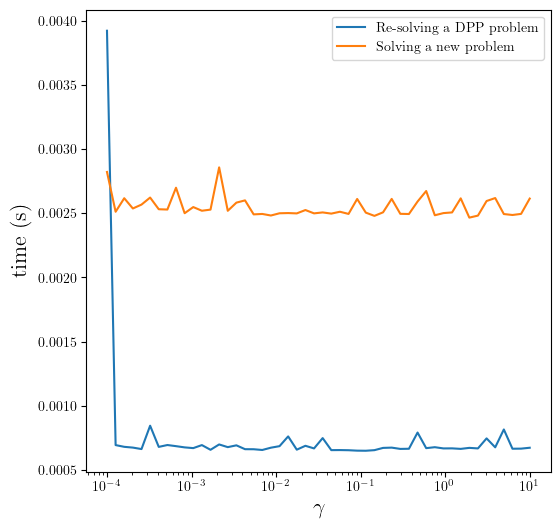

In [9]:
import cvxpy as cp
import numpy
import matplotlib.pyplot as plt
import time

n = 15
m = 10
numpy.random.seed(1)
A = numpy.random.randn(n, m)
b = numpy.random.randn(n)
# gamma must be nonnegative due to DCP rules.
gamma = cp.Parameter(nonneg=True)

x = cp.Variable(m)
error = cp.sum_squares(A @ x - b)
obj = cp.Minimize(error + gamma*cp.norm(x, 1))
problem = cp.Problem(obj)
assert problem.is_dcp(dpp=True)

gamma_vals = numpy.logspace(-4, 1)
times = []
new_problem_times = []
for val in gamma_vals:
    gamma.value = val
    start = time.time()
    problem.solve()
    end = time.time()
    times.append(end - start)
    new_problem = cp.Problem(obj)
    start = time.time()
    new_problem.solve()
    end = time.time()
    new_problem_times.append(end - start)

plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.figure(figsize=(6, 6))
plt.plot(gamma_vals, times, label='Re-solving a DPP problem')
plt.plot(gamma_vals, new_problem_times, label='Solving a new problem')
plt.xlabel(r'$\gamma$', fontsize=16)
plt.ylabel(r'time (s)', fontsize=16)
plt.xscale('log')
plt.legend()
plt.plot()

Similar speed-ups can be obtained for DGP problems.

#### Sensitivity analysis and gradients

An optimization problem can be viewed as a function mapping parameters to solutions. This solution map is sometimes differentiable. CVXPY has built-in support for computing the derivative of the optimal variable values of a problem with respect to small perturbations of the parameters (i.e., the Parameter instances appearing in a problem).

The problem class exposes two methods related to computing the derivative. The derivative evaluates the derivative given perturbations to the parameters. This lets you calculate how the solution to a problem would change given small changes to the parameters, without re-solving the problem. The backward method evaluates the adjoint of the derivative, computing the gradient of the solution with respect to the parameters. This can be useful when combined with automatic differentiation software.

The derivative and backward methods are only meaningful when the problem contains parameters. In order for a problem to be differentiable, it must be DPP-compliant. CVXPY can compute the derivative of any DPP-compliant DCP or DGP problem. At non-differentiable points, CVXPY computes a heuristic quantity.



Example.

As a first example, we solve a trivial problem with an analytical solution, to illustrate the usage of the backward and derivative functions. In the following block of code, we construct a problem with a scalar variable x and a scalar parameter p. The problem is to minimize the quadratic (x - 2*p)**2.

In [10]:
import cvxpy as cp

x = cp.Variable()
p = cp.Parameter()
quadratic = cp.square(x - 2 * p)
problem = cp.Problem(cp.Minimize(quadratic))


Next, we solve the problem for the particular value of p == 3. Notice that when solving the problem, we supply the keyword argument requires_grad=True to the solve method.

In [11]:
p.value = 3.
problem.solve(requires_grad=True)

2.8398992587956425e-29

Having solved the problem with requires_grad=True, we can now use the backward and derivative to differentiate through the problem. First, we compute the gradient of the solution with respect to its parameter by calling the backward() method. As a side-effect, the backward() method populates the gradient attribute on all parameters with the gradient of the solution with respect to that parameter.



In [12]:
problem.backward()
print("The gradient is {0:0.1f}.".format(p.gradient))

The gradient is 2.0.


In this case, the problem has the trivial analytical solution 2*p, and the gradient is therefore just 2. So, as expected, the above code prints

The gradient is 2.0.
Next, we use the derivative method to see how a small change in p would affect the solution x. We will perturb p by 1e-5, by setting p.delta = 1e-5, and calling the derivative method will populate the delta attribute of x with the the change in x predicted by a first-order approximation (which is dx/dp * p.delta).

In [13]:
p.delta = 1e-5
problem.derivative()
print("x.delta is {0:2.1g}.".format(x.delta))


x.delta is 2e-05.


In this case the solution is trivial and its derivative is just 2*p, so we know that the delta in x should be 2e-5. As expected, the output is

x.delta is 2e-05.

We emphasize that this example is trivial, because it has a trivial analytical solution, with a trivial derivative. The backward() and forward() methods are useful because the vast majority of convex optimization problems do not have analytical solutions: in these cases, CVXPY can compute solutions and their derivatives, even though it would be impossible to derive them by hand.

Note. In this simple example, the variable x was a scalar, so the backward method computed the gradient of x with respect to p. When there is more than one scalar variable, by default, backward computes the gradient of the sum of the optimal variable values with respect to the parameters.

More generally, the backward method can be used to compute the gradient of a scalar-valued function f of the optimal variables, with respect to the parameters. If x(p) denotes the optimal value of the variable (which might be a vector or a matrix) for a particular value of the parameter p and f(x(p)) is a scalar, then backward can be used to compute the gradient of f with respect to p. Let x* = x(p), and say the derivative of f with respect to x* is dx. To compute the derivative of f with respect to p, before calling problem.backward(), just set x.gradient = dx.

The backward method can be powerful when combined with software for automatic differentiation. We recommend the software package CVXPY Layers, which provides differentiable PyTorch and TensorFlow wrappers for CVXPY problems.

backward or derivative? The backward method should be used when you need the gradient of (a scalar-valued function) of the solution, with respect to the parameters. If you only want to do a sensitivity analysis, that is, if all you’re interested in is how the solution would change if one or more parameters were changed, you should use the derivative method. When there are multiple variables, it is much more efficient to compute sensitivities using the derivative method than it would be to compute the entire Jacobian (which can be done by calling backward multiple times, once for each standard basis vector).